In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        rand_start = np.random.rand(batch_size,1)
        ts_start = rand_start*(self.xmax - self.xmin - (steps*self.resolution))
        batch_ts = ts_start + np.arange(0.0,steps+1)*self.resolution
        y_batch = np.sin(batch_ts)
        
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1),batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1)

In [3]:
ts_data = TimeSeriesData(250,0,10)

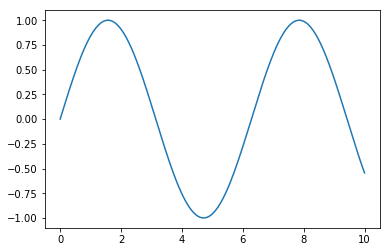

In [4]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [5]:
num_time_steps = 30

In [6]:
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)

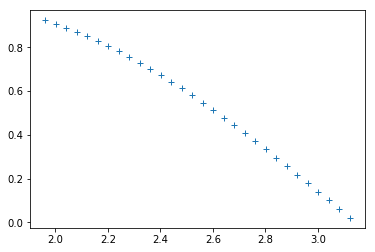

In [7]:
plt.plot(ts.flatten()[1:],y2.flatten(),'+')

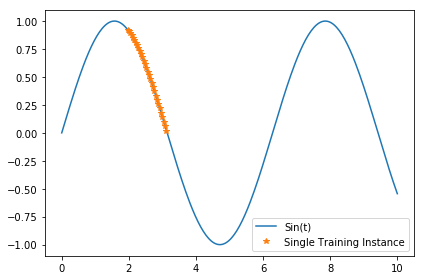

In [34]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label="Single Training Instance")
plt.tight_layout()
plt.legend()

In [9]:
train_inst = np.linspace(5,5+ts_data.resolution*(num_time_steps+1),num_time_steps+1)

In [10]:
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

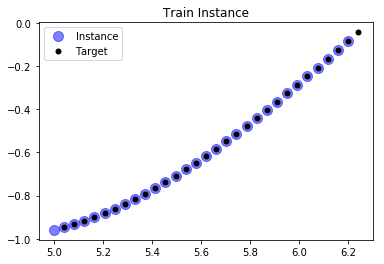

In [11]:
plt.title('Train Instance')
plt.plot(train_inst[:-1],ts_data.ret_true(train_inst[:-1]),'bo',markersize = 10,alpha = 0.5,label = "Instance")
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]),'ko',markersize = 5,label = "Target")
plt.legend()

In [12]:
tf.reset_default_graph()

In [13]:
num_input = 1

In [14]:
learning_rate = 0.001

In [15]:
num_neurons = 100

In [16]:
num_outputs = 1

In [17]:
num_train_iterations = 2000

In [18]:
batch_size = 1

In [19]:
X = tf.placeholder(tf.float32,shape = [None,num_time_steps,num_input])

In [20]:
y = tf.placeholder(tf.float32,shape = [None,num_time_steps,num_outputs])

In [21]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.GRUCell(num_neurons,tf.nn.relu),num_outputs)

In [22]:
output, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [23]:
loss = tf.reduce_mean(tf.square(output-y))

In [24]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [25]:
train = optimizer.minimize(loss)

In [26]:
init = tf.global_variables_initializer()

In [27]:
saver = tf.train.Saver()

In [28]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(num_train_iterations):
        
        X_batch,y_batch = ts_data.next_batch(batch_size,num_time_steps)
        
        sess.run(train,feed_dict = {X:X_batch,y:y_batch})
        if i % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(i,"\tMSE",mse)
    saver.save(sess,"./rnn_time_series_model_27-05-20")
    

0 	MSE 0.319339
100 	MSE 0.0481102
200 	MSE 0.0120211
300 	MSE 0.0168967
400 	MSE 0.0139817
500 	MSE 0.0102249
600 	MSE 0.00797044
700 	MSE 0.000735376
800 	MSE 0.000707587
900 	MSE 0.000182693
1000 	MSE 0.000234911
1100 	MSE 0.000654876
1200 	MSE 0.000178081
1300 	MSE 0.000133442
1400 	MSE 0.000387605
1500 	MSE 3.15871e-05
1600 	MSE 2.83327e-05
1700 	MSE 0.000257648
1800 	MSE 2.72969e-05
1900 	MSE 1.7418e-05


In [29]:
with tf.Session() as sess:
    saver.restore(sess,"./rnn_time_series_model_27-05-20")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_input)))
    y_pred = sess.run(output,feed_dict={X:X_new})
    

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model_27-05-20


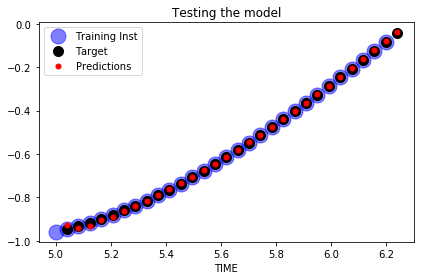

In [30]:
plt.title("Testing the model")

plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha = 0.5,label="Training Inst")

plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize=10,label="Target")

plt.plot(train_inst[1:],y_pred[0,:,0],"r.",markersize=10,label="Predictions")

plt.xlabel('TIME')

plt.legend()
plt.tight_layout()

